In [44]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')
from tools import VasicekModel, LoanPortfolio

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Vasicek (CreditMetrics) Model and Homogeneous Portfolio

## Vasicek (CreditMetrics) Model
Log-return $r_b$ of borrower's asset is defined by
$$
r_b = \beta_bX_b +\sqrt{1-\beta_b^2}\varepsilon_b
$$
where
$X_b$ is a normally distributed (systemic) factor
$$
    X_b=\sum_{k=1}^K \alpha_{b,k}Y_k
$$
and $\varepsilon$ is is an  normally distributed idiosyncratic risk factor.

The obligor defaults if
$$
r_b<\theta_b
$$
for a fixed threshold $theta_b$ that is determined by the estimated default probability $pd_b$ via the relation
$$pd_b=\phi(\theta_b)$$.

In case of default, the loss of the investor that invested $N_b$ into the loan is given by $N_b \mbox{LGD}_b$ where $LGD_b$ is the so-called loss given default (the percentage that cannot be recovered).

For a portfolio of $B$ loans the loss is given by
$$
L = \sum_{b=1}I_{r_b<\theta_b}N_b\mbox{LGD}_b
$$

### 1 systemic risk factor

In [221]:
n_loans = 2000

if False:
    betas = 0.5*np.ones((n_loans,))
    pds = 0.05*np.ones((n_loans,))
    lgds = 0.7*np.ones((n_loans,))
    notionals = np.ones((n_loans,))
else:
    betas =np.random.uniform(0.4,0.5,size=(n_loans,))
    pds = np.random.uniform(0.01,0.1,size=(n_loans,))
    lgds = np.random.uniform(0.5,0.7, size=(n_loans,))
    notionals = np.random.uniform(0.1,1.0, size=(n_loans,))#np.ones((n_loans,))/n_loans

notionals /= np.sum(notionals)                         
vasicek_model = VasicekModel(betas = betas, 
                             pds=pds,
                            notionals = notionals,
                            lgds = lgds
                            )

In [222]:
n_sims = 100_000
vasicek_loss = np.empty((n_sims, ))
for i in range(n_sims):
    vasicek_model.simulate(np.random.uniform(0.0,1.0,(vasicek_model.random_variates_shape())))
    vasicek_loss[i] = vasicek_model.compute_default_loss()

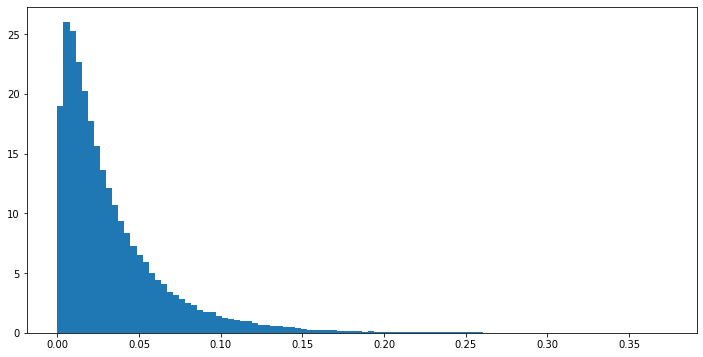

In [223]:
plt.figure(figsize=(12,6))
plt.hist(vasicek_loss, bins=100, density = True);

### 2 systemic risk factors

Here we assume two uncorrelated systemic risk factors $Y_1$ and $Y_2$ where the different loans can be grouped into three categories:
- loans that do only depend on the first risk factor $Y_1$, i.e. $\alpha_{b,1}=1$ and $\alpha_{b,2}=0$
- loans that do only depend on the second risk factor $Y_2$, i.e. $\alpha_{b,1}=0$ and $\alpha_{b,2}=1$
- loans that depend on both risk factors, i.e. $\alpha_{b,1}\not=0.0$ and $\alpha_{b,2}\not=0.0$

In [187]:
alphas = np.zeros((n_loans,2))
if False:
    alphas[:int(n_loans/3), 0] = 1.0
    alphas[int(n_loans/3):int(2*n_loans/3), 1] = 1.0
    alphas[int(2*n_loans/3):, 0] = 0.5
    alphas[int(2*n_loans/3):, 1] = 0.5
else:
    alphas[:int(n_loans/2), 0] = 1.0
    alphas[int(n_loans/2):, 1] = 1.0
vasicek_model_2 = VasicekModel(betas = betas, 
                             pds=pds,
                            notionals = notionals,
                            lgds = lgds,
                            alphas = alphas
                            )
n_sims = 100_000
vasicek_loss_2 = np.empty((n_sims, ))
for i in range(n_sims):
    vasicek_model_2.simulate(np.random.uniform(0.0,1.0,(vasicek_model_2.random_variates_shape())))
    vasicek_loss_2[i] = vasicek_model_2.compute_default_loss()

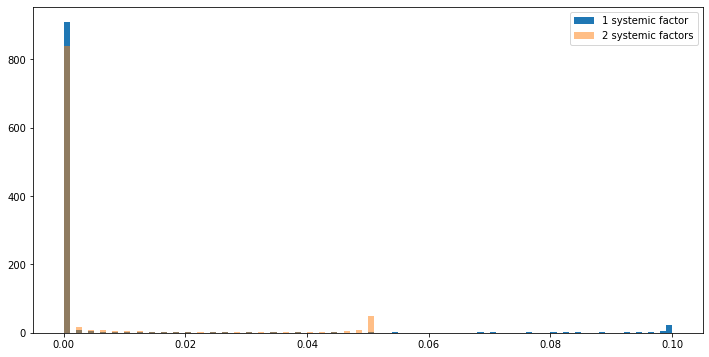

In [188]:
plt.figure(figsize=(12,6))
plt.hist(vasicek_loss, bins=100, density = True, label='1 systemic factor')
plt.hist(vasicek_loss_2, bins=100, density = True, alpha=0.5, label='2 systemic factors')
plt.legend();

## The homogeneous portfolio

Under the condition that all loans have the same systemic factor $X$, the same deafult probability $pd_b=pd$  and the same loss given default $LGD_b=LGD$ one can show (Gordy)
$$
    L = \sum_{b=1}I_{r_b<\phi^{-1}(pd)}N_b\mbox{LGD}_b \approx N\cdot LGD\phi\left(\frac{\phi^{-1}(pd)+\beta X}{\sqrt{1-\beta^2}} \right)
$$
where $N=\sum_bN_b$.

In [224]:
loan_portfolio = LoanPortfolio(lgd = np.mean(lgds), r=0.0, pd = np.mean(pds), beta = np.mean(betas))
loss_homogeneous_ptf = loan_portfolio.compute_loss(np.random.normal(size=n_sims))

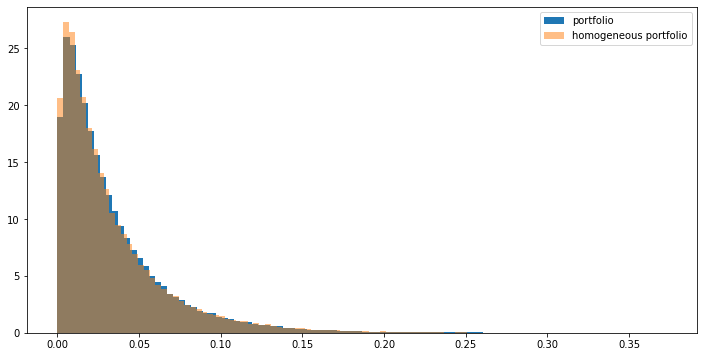

In [225]:
plt.figure(figsize=(12,6))
plt.hist(vasicek_loss, bins=100, density = True, label='portfolio')
plt.hist(loss_homogeneous_ptf, bins=100, alpha=0.5, density = True, label='homogeneous portfolio')
plt.legend();

In [226]:
q = 0.999
VaR_vasicek = np.quantile(vasicek_loss, q)
VaR_homogeneous = np.quantile(loss_homogeneous_ptf, q)
print('Vasicek: ', VaR_vasicek, ', approximated: ', VaR_homogeneous)
ES_vasicek = vasicek_loss[vasicek_loss>=VaR_vasicek].mean()
ES_homogeneous = loss_homogeneous_ptf[loss_homogeneous_ptf>=VaR_homogeneous].mean()
print('Vasicek: ', ES_vasicek, ', approximated: ', ES_homogeneous)

Vasicek:  0.2421970333769619 , approximated:  0.24665807185613295
Vasicek:  0.26800480168984725 , approximated:  0.2751663000208418
